# Soving a Social Distancing Problem with Genetic Algorithms

Blog post with more explanation can be found at: 
https://medium.com/@st3llasia/solving-a-social-distancing-problem-using-genetic-algorithms-e5f1709c87a1

## The problem

- 20 guests from 11 families are invited to join a barbecue (replace barbecue with wedding, Thanksgiving dinner, whatever party depending on the time of the year)
- You can place them on 6 tables having 6 seats each, where two consecutive seats are one-meter apart from each other (we consider tables are circular)
- Each table must contain guests from at least two different families
- Each table must not have more than two guests from the same family
- Guests from different families must be seated at least two meters apart from each other

## Solution using GA

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import random
import numpy as np
from collections import Counter, deque
from deap import base, creator, tools, algorithms

Data was provided as a csv file, repeated here for completeness. The first column is the guest's name while the second column tells us which family (s)he belongs to. The first step is to parse this file. For now, let's just save this information into a dictionary whose keys are the names and values are the families:

In [2]:
data = """Host,A
Jane,B
Jun,C
Oliver,C
Mia,D
Sophie,D
Milan,D
Jeremy,D
Avery,E
Hugo,F
Mohamed,G
Maria,H
Aarav,H
Rowan,I
Ren,I
Ali,J
Hannah,J
Fatima,K
Marc,K
Isabella,K
"""

guests = dict(
    d.split(",") for d in data.split("\n") if d
)
guests

{'Host': 'A',
 'Jane': 'B',
 'Jun': 'C',
 'Oliver': 'C',
 'Mia': 'D',
 'Sophie': 'D',
 'Milan': 'D',
 'Jeremy': 'D',
 'Avery': 'E',
 'Hugo': 'F',
 'Mohamed': 'G',
 'Maria': 'H',
 'Aarav': 'H',
 'Rowan': 'I',
 'Ren': 'I',
 'Ali': 'J',
 'Hannah': 'J',
 'Fatima': 'K',
 'Marc': 'K',
 'Isabella': 'K'}

In [3]:
# problem parameters
GUESTS = guests
NUM_TABLES = 6
NUM_SEATS_PER_TABLE = 6

The core of the algorithm lies in the way we compute the `fitness`, ie an indication to how close a solution is to the 'best' solution. An implementation counting how many 'violations' to the problem rules a solution contains is implemented below. The lower the fitness, the better the solution and the higher its chances to be kept for the next generation.
Note that, to ensute that each seat is assigned only once, a very high fitness is used for solutions that do not meet this criteria (high = bad).

In [4]:
def seats_to_2d_tables(solution):
    """Transforms a solution vector of length len(GUESTS) into a 2d matrix
    with size (NUM_TABLES, NUM_SEATS_PER_TABLE)
    Element ij of the matrix is equal to the family of the assigned person, 
    or -1 if no guest is assigned this seat.
    """
    # initialize the matrix with all elements = -1
    tables = [
        [-1 for j in range(NUM_SEATS_PER_TABLE)]
        for i in range(NUM_TABLES)
    ]
    guest_names = list(GUESTS.keys())
    for guest_id, table_seat in enumerate(solution):
        table, seat = divmod(table_seat, NUM_SEATS_PER_TABLE)
        guest_name = guest_names[guest_id]
        tables[table][seat] = GUESTS[guest_name]
    return tables


def get_fitness(solution, verbose=False):
    """
    Calculates the number of violations in the given solution
    :param solution: a list of indices corresponding to the positions of the queens in each row
    :param bool verbose: if True, prints some intermediate results to understand the fitness decomposition
    :return: a tuple containing the calculated value
    :rtype: tuple
    """

    c = Counter(solution)
    if any( v > 1 for v in c.values()):
        return (100, )

    # we fill a 2d array representing the tables
    tables = seats_to_2d_tables(solution)

    violations = 0
    for table in tables:
        if verbose:
            print("="* 10, table)
        v = 0  # violations for this table

        # each table must contain guests from at least two families
        c = Counter([k for k in table if k != -1])  # count number of families per table
        if len(c) < 2:  # allow for empty tables (extra rule)
            v += 1

        # each table must not have more than 2 guests from the same family
        s = sum(v > 2 for k, v in c.items())
        v += s

        if verbose:
            print(c)
            print("v1 =", v)
            print("s =", s)

        # people from different families must be at least 2 seats apart
        td = deque(table) 
        tdr = deque(table)  # table rotated
        tdr.rotate()
        for seat, prev_seat in zip(td, tdr):
            if seat == -1 or prev_seat == -1:
                continue
            if seat != prev_seat:
                if verbose:
                    print(seat, prev_seat)
                v += 1
        if verbose:
            print("v_f =", v)
        violations += v
    return (violations, )
    
# solution = [20, 32, 24, 25, 34, 10, 14, 11, 1, 28, 30, 3, 4, 8, 7, 21, 12, 18, 16, 23]
# print("Number of violations = ", get_fitness(solution, verbose=True))

Next, we can implement the GA using the `deap` package. You will find below each of the steps described in the blog post mentioned above:

- Initial population generation, from a random selection of NB_GUESTS seats (between 0 and NUM_TABLES * NUM_SEATS_PER_TABLE)
- Fitness calculation using the above defined function
- Selection, cross-over and mutation methods definition (more about that in https://deap.readthedocs.io/en/master/tutorials/basic/part2.html):
    - Selection: [*tournament*](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.selTournament): solutions are compared two by two and the one with the lowest fitness is kept for the next generation [Wikipedia link](https://en.wikipedia.org/wiki/Tournament_selection)
    - Cross-over: [*cxTwoPoint*](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.cxTwoPoint):
     
         ![Two points cross over illustration from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/c/cd/TwoPointCrossover.svg)
  
    - Mutation: [*mutShuffleIndexes*](https://deap.readthedocs.io/en/master/api/tools.html#deap.tools.mutShuffleIndexes): shuffle the indices in each solution with a probability P_MUTATION

In [5]:
# the code in this cell is heavily inspired from:
# https://github.com/PacktPublishing/Hands-On-Genetic-Algorithms-with-Python/blob/master/Chapter05/01-solve-n-queens.py

# set the random seed for repeatable results
RANDOM_SEED = 1234
random.seed(RANDOM_SEED)


# Genetic Algorithm parameters
POPULATION_SIZE = 300
MAX_GENERATIONS = 100
P_CROSSOVER = 0.9  # probability for crossover
P_MUTATION = 0.4   # probability for mutating an individual

HALL_OF_FAME_SIZE = 10


# start algorithm configuration
toolbox = base.Toolbox()

# define a single objective, minimizing fitness strategy
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))

# create the Individual class (list of integers)
creator.create("Individual", list, typecode='i', fitness=creator.FitnessMin)

# create an operator that generates randomly shuffled indices
toolbox.register("randomOrder", lambda : random.sample(range(NUM_TABLES * NUM_SEATS_PER_TABLE), k=len(GUESTS)))
# create the individual creation operator to fill up an Individual instance with shuffled indices
toolbox.register("individualCreator", tools.initIterate, creator.Individual, toolbox.randomOrder)
# create the population creation operator to generate a list of individuals
toolbox.register("populationCreator", tools.initRepeat, list, toolbox.individualCreator)

# fitness calculation - compute the total distance of the list of cities represented by indices
toolbox.register("evaluate", get_fitness)
# Genetic operators
toolbox.register("select", tools.selTournament, tournsize=10)
toolbox.register("mate", tools.cxTwoPoint)
toolbox.register("mutate", tools.mutShuffleIndexes, indpb=1.0/len(GUESTS))


# create initial population (generation 0):
population = toolbox.populationCreator(n=POPULATION_SIZE)

Finally, we have prepared our algorithm, we can run it, saving some statistics for each generation (min, average and median value of the fitness function) and the "Hall of Fame", meaning the best performing individuals, regardless of their generation:

In [6]:
# prepare the statistics object:
stats = tools.Statistics(lambda ind: ind.fitness.values)
stats.register("min", np.min)
stats.register("avg", np.mean)
stats.register("med", np.median)

# define the hall-of-fame object to keep 'best' candidates, regardless of the generation they belong to
hof = tools.HallOfFame(HALL_OF_FAME_SIZE)

population, logbook = algorithms.eaSimple(population, toolbox, cxpb=P_CROSSOVER, mutpb=P_MUTATION,
                                          ngen=MAX_GENERATIONS, stats=stats, halloffame=hof, verbose=False)

# print hall of fame members info:
for i in range(HALL_OF_FAME_SIZE):
    print(i, ": ", hof.items[i].fitness.values[0], " -> ", hof.items[i])

0 :  0.0  ->  [10, 31, 19, 20, 23, 35, 22, 5, 6, 13, 3, 17, 33, 8, 1, 28, 27, 24, 25, 15]
1 :  0.0  ->  [10, 35, 19, 20, 31, 23, 22, 5, 6, 13, 3, 17, 33, 8, 1, 28, 27, 24, 25, 15]
2 :  0.0  ->  [6, 31, 19, 20, 35, 23, 22, 5, 10, 1, 3, 17, 33, 8, 13, 28, 27, 24, 25, 15]
3 :  0.0  ->  [10, 31, 19, 20, 35, 23, 22, 33, 6, 13, 3, 17, 5, 8, 1, 28, 27, 24, 25, 15]
4 :  0.0  ->  [10, 31, 19, 20, 35, 23, 22, 5, 6, 3, 13, 17, 33, 8, 1, 28, 27, 24, 25, 15]
5 :  0.0  ->  [10, 31, 19, 20, 35, 23, 22, 5, 6, 13, 3, 17, 33, 8, 1, 27, 28, 24, 25, 15]
6 :  0.0  ->  [33, 31, 19, 20, 35, 23, 22, 5, 6, 13, 3, 17, 1, 8, 15, 28, 27, 24, 25, 10]
7 :  0.0  ->  [10, 31, 19, 20, 35, 23, 22, 5, 15, 13, 3, 17, 33, 8, 1, 28, 27, 24, 25, 6]
8 :  0.0  ->  [10, 31, 19, 20, 35, 22, 23, 5, 6, 13, 3, 17, 33, 8, 1, 28, 27, 24, 25, 15]
9 :  0.0  ->  [10, 31, 19, 20, 35, 23, 22, 5, 6, 13, 3, 17, 33, 8, 1, 28, 27, 24, 25, 15]


Let's first plot the evolution of the fitness function over generations, out of curiosity:

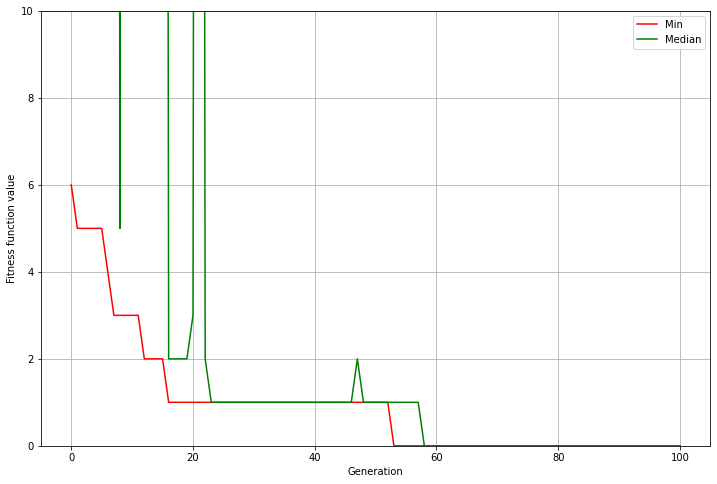

In [7]:
min_fitness_values, avg_fitness_values = logbook.select("min", "med")

plt.figure(figsize=(12, 8))
plt.plot(min_fitness_values, color='red', label="Min")
plt.plot(avg_fitness_values, color='green', label="Median")

plt.xlabel("Generation")
plt.ylabel("Fitness function value")
plt.ylim(0, 10)
plt.legend()
plt.grid()
plt.show()

Finally, with the help of the `print_solution` function, we can display the result, meaning the guest disposition that satisfies all the constraints. 

As you can see in the Hall of Fame, the algorithms has found several solutions matching the criteria (fitness=0, meaning no violations from the rules), so we can display a few of them with the same function:

In [8]:
def print_solution(solution):
    """Nicely prints the guests with their table and seat position.

    :param list solution: list of seats for each guest (len(solution) = len(GUESTS))
    :rtype: None
    """
    tables = [
        [-1 for j in range(NUM_SEATS_PER_TABLE)]
        for i in range(NUM_TABLES)
    ]
    guest_names = list(GUESTS.keys())
    for guest_id, table_seat in enumerate(solution):
        table, seat = divmod(table_seat, NUM_SEATS_PER_TABLE)
        guest_name = guest_names[guest_id]
        guest_family = GUESTS[guest_name]
        tables[table][seat] = f"{guest_name} ({guest_family})"

    for t in tables:
        for s in t:
            print("{:>13}".format(s), end="")
        print()

print_solution(hof.items[0])

           -1      Ren (I)           -1  Mohamed (G)           -1   Jeremy (D)
    Avery (E)           -1    Rowan (I)           -1     Host (A)           -1
           -1     Hugo (F)           -1 Isabella (K)           -1    Maria (H)
           -1      Jun (C)   Oliver (C)           -1    Milan (D)      Mia (D)
   Fatima (K)     Marc (K)           -1   Hannah (J)      Ali (J)           -1
           -1     Jane (B)           -1    Aarav (H)           -1   Sophie (D)


In [9]:
print_solution(hof.items[1])

           -1      Ren (I)           -1  Mohamed (G)           -1   Jeremy (D)
    Avery (E)           -1    Rowan (I)           -1     Host (A)           -1
           -1     Hugo (F)           -1 Isabella (K)           -1    Maria (H)
           -1      Jun (C)   Oliver (C)           -1    Milan (D)   Sophie (D)
   Fatima (K)     Marc (K)           -1   Hannah (J)      Ali (J)           -1
           -1      Mia (D)           -1    Aarav (H)           -1     Jane (B)


In [10]:
print_solution(hof.items[2])

           -1     Hugo (F)           -1  Mohamed (G)           -1   Jeremy (D)
     Host (A)           -1    Rowan (I)           -1    Avery (E)           -1
           -1      Ren (I)           -1 Isabella (K)           -1    Maria (H)
           -1      Jun (C)   Oliver (C)           -1    Milan (D)   Sophie (D)
   Fatima (K)     Marc (K)           -1   Hannah (J)      Ali (J)           -1
           -1     Jane (B)           -1    Aarav (H)           -1      Mia (D)
